# `causalml` - Meta-Learner Example Notebook
This notebook only contains regression examples.

In [1]:
# pick the right base path (only run ONCE)
import os
base_path = os.path.abspath("../")
os.chdir(base_path)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
import warnings

# from causalml.inference.meta import XGBTLearner, MLPTLearner
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.meta import LRSRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# imports from package
import logging
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from copy import deepcopy

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

%matplotlib inline

Using TensorFlow backend.


# Single Treatment Case

### Generate synthetic data

In [4]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array(['treatment_a' if val==1 else 'control' for val in treatment])

## S-Learner

### ATE

In [5]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False, bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9642
INFO:causalml:    RMSE (Treatment):     0.9653
INFO:causalml:   sMAPE   (Control):     0.8250
INFO:causalml:   sMAPE (Treatment):     0.4682
INFO:causalml:    Gini   (Control):     0.4654
INFO:causalml:    Gini (Treatment):     0.4941


In [6]:
ate_s

array([0.5577983])

### ATE w/ Confidence Intervals

In [7]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                   bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9642
INFO:causalml:    RMSE (Treatment):     0.9653
INFO:causalml:   sMAPE   (Control):     0.8250
INFO:causalml:   sMAPE (Treatment):     0.4682
INFO:causalml:    Gini   (Control):     0.4654
INFO:causalml:    Gini (Treatment):     0.4941


In [8]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.5197129],
       [0.5577983],
       [0.5958837]])

### ATE w/ Boostrap Confidence Intervals

In [9]:
ate_s_b, ate_s_lb_b, ate_s_ub_b = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                         bootstrap_ci=True, n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9642
INFO:causalml:    RMSE (Treatment):     0.9653
INFO:causalml:   sMAPE   (Control):     0.8250
INFO:causalml:   sMAPE (Treatment):     0.4682
INFO:causalml:    Gini   (Control):     0.4654
INFO:causalml:    Gini (Treatment):     0.4941
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


In [10]:
np.vstack((ate_s_lb_b, ate_s_b, ate_s_ub_b))

array([[0.48767755],
       [0.5577983 ],
       [0.62262745]])

### CATE

In [11]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9642
INFO:causalml:    RMSE (Treatment):     0.9653
INFO:causalml:   sMAPE   (Control):     0.8250
INFO:causalml:   sMAPE (Treatment):     0.4682
INFO:causalml:    Gini   (Control):     0.4654
INFO:causalml:    Gini (Treatment):     0.4941


In [12]:
cate_s

array([[0.67405117],
       [0.63909245],
       [0.25836706],
       ...,
       [0.38459313],
       [0.74323356],
       [0.7728349 ]])

### CATE w/ Confidence Intervals

In [13]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9642
INFO:causalml:    RMSE (Treatment):     0.9653
INFO:causalml:   sMAPE   (Control):     0.8250
INFO:causalml:   sMAPE (Treatment):     0.4682
INFO:causalml:    Gini   (Control):     0.4654
INFO:causalml:    Gini (Treatment):     0.4941
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


In [14]:
cate_s

array([[0.67405117],
       [0.63909245],
       [0.25836706],
       ...,
       [0.38459313],
       [0.74323356],
       [0.7728349 ]])

In [15]:
cate_s_lb

array([[0.40813417],
       [0.46955505],
       [0.1254503 ],
       ...,
       [0.19305494],
       [0.43469266],
       [0.50259018]])

In [16]:
cate_s_ub

array([[0.83760878],
       [0.9223401 ],
       [0.67172733],
       ...,
       [0.60543364],
       [0.86951138],
       [1.0190843 ]])

## T-Learner

### ATE w/ Confidence Intervals

In [17]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9482
INFO:causalml:    RMSE (Treatment):     0.9346
INFO:causalml:   sMAPE   (Control):     0.8136
INFO:causalml:   sMAPE (Treatment):     0.4594
INFO:causalml:    Gini   (Control):     0.4991
INFO:causalml:    Gini (Treatment):     0.5394


In [18]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.54203293],
       [0.57965379],
       [0.61727465]])

### ATE w/ Boostrap Confidence Intervals

In [19]:
ate_t_b, ate_t_lb_b, ate_t_ub_b = learner_t.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9482
INFO:causalml:    RMSE (Treatment):     0.9346
INFO:causalml:   sMAPE   (Control):     0.8136
INFO:causalml:   sMAPE (Treatment):     0.4594
INFO:causalml:    Gini   (Control):     0.4991
INFO:causalml:    Gini (Treatment):     0.5394
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


In [20]:
np.vstack((ate_t_lb_b, ate_t_b, ate_t_ub_b))

array([[0.5350495 ],
       [0.57965379],
       [0.64942914]])

### CATE

In [21]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9482
INFO:causalml:    RMSE (Treatment):     0.9346
INFO:causalml:   sMAPE   (Control):     0.8136
INFO:causalml:   sMAPE (Treatment):     0.4594
INFO:causalml:    Gini   (Control):     0.4991
INFO:causalml:    Gini (Treatment):     0.5394


In [22]:
cate_t

array([[0.66688871],
       [0.76726997],
       [0.40129769],
       ...,
       [0.34615451],
       [0.73604703],
       [1.059165  ]])

### CATE w/ Confidence Intervals

In [23]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9482
INFO:causalml:    RMSE (Treatment):     0.9346
INFO:causalml:   sMAPE   (Control):     0.8136
INFO:causalml:   sMAPE (Treatment):     0.4594
INFO:causalml:    Gini   (Control):     0.4991
INFO:causalml:    Gini (Treatment):     0.5394
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


In [24]:
cate_t

array([[0.66688871],
       [0.76726997],
       [0.40129769],
       ...,
       [0.34615451],
       [0.73604703],
       [1.059165  ]])

In [25]:
cate_t_lb

array([[ 0.18670778],
       [ 0.27689289],
       [-0.38532938],
       ...,
       [-0.10780833],
       [-0.05583749],
       [ 0.28756618]])

In [26]:
cate_t_ub

array([[1.05013069],
       [1.5060878 ],
       [1.2316293 ],
       ...,
       [0.78909829],
       [1.20617873],
       [1.39304497]])

## X-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [5]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9564
INFO:causalml:    RMSE (Treatment):     0.9469
INFO:causalml:   sMAPE   (Control):     0.8125
INFO:causalml:   sMAPE (Treatment):     0.4689
INFO:causalml:    Gini   (Control):     0.5060
INFO:causalml:    Gini (Treatment):     0.5422


In [6]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.47330262],
       [0.51089615],
       [0.54848969]])

#### Without Propensity Score input

In [7]:
ate_x_no_p, ate_x_lb_no_p, ate_x_ub_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9564
INFO:causalml:    RMSE (Treatment):     0.9469
INFO:causalml:   sMAPE   (Control):     0.8125
INFO:causalml:   sMAPE (Treatment):     0.4689
INFO:causalml:    Gini   (Control):     0.5060
INFO:causalml:    Gini (Treatment):     0.5422


In [8]:
np.vstack((ate_x_lb_no_p, ate_x_no_p, ate_x_ub_no_p))

array([[0.47805661],
       [0.51565263],
       [0.55324865]])

In [9]:
learner_x.propensity_model

{'treatment_a': {'all training': ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
               l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
               normalize=False, positive=False, precompute='auto',
               random_state=None, selection='cyclic', tol=0.0001, verbose=0)}}

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [10]:
ate_x_b, ate_x_lb_b, ate_x_ub_b = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9564
INFO:causalml:    RMSE (Treatment):     0.9469
INFO:causalml:   sMAPE   (Control):     0.8125
INFO:causalml:   sMAPE (Treatment):     0.4689
INFO:causalml:    Gini   (Control):     0.5060
INFO:causalml:    Gini (Treatment):     0.5422
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


In [11]:
np.vstack((ate_x_lb_b, ate_x_b, ate_x_ub_b))

array([[0.45572911],
       [0.51089615],
       [0.58604202]])

#### Without Propensity Score Input

In [12]:
ate_x_b_no_p, ate_x_lb_b_no_p, ate_x_ub_b_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9564
INFO:causalml:    RMSE (Treatment):     0.9469
INFO:causalml:   sMAPE   (Control):     0.8125
INFO:causalml:   sMAPE (Treatment):     0.4689
INFO:causalml:    Gini   (Control):     0.5060
INFO:causalml:    Gini (Treatment):     0.5422
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


In [13]:
np.vstack((ate_x_lb_b_no_p, ate_x_b_no_p, ate_x_ub_b_no_p))

array([[0.44200236],
       [0.51565263],
       [0.61570334]])

### CATE

#### With Propensity Score Input

In [14]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9564
INFO:causalml:    RMSE (Treatment):     0.9469
INFO:causalml:   sMAPE   (Control):     0.8125
INFO:causalml:   sMAPE (Treatment):     0.4689
INFO:causalml:    Gini   (Control):     0.5060
INFO:causalml:    Gini (Treatment):     0.5422


In [15]:
cate_x

array([[0.64728995],
       [0.17048343],
       [0.59343035],
       ...,
       [0.36880914],
       [0.3855286 ],
       [0.52568257]])

#### Without Propensity Score Input

In [16]:
cate_x_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9564
INFO:causalml:    RMSE (Treatment):     0.9469
INFO:causalml:   sMAPE   (Control):     0.8125
INFO:causalml:   sMAPE (Treatment):     0.4689
INFO:causalml:    Gini   (Control):     0.5060
INFO:causalml:    Gini (Treatment):     0.5422


In [17]:
cate_x_no_p

array([[0.62232483],
       [0.16952558],
       [0.59285835],
       ...,
       [0.42491517],
       [0.38981706],
       [0.53986474]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [18]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9564
INFO:causalml:    RMSE (Treatment):     0.9469
INFO:causalml:   sMAPE   (Control):     0.8125
INFO:causalml:   sMAPE (Treatment):     0.4689
INFO:causalml:    Gini   (Control):     0.5060
INFO:causalml:    Gini (Treatment):     0.5422
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


In [19]:
cate_x

array([[0.64728995],
       [0.17048343],
       [0.59343035],
       ...,
       [0.36880914],
       [0.3855286 ],
       [0.52568257]])

In [20]:
cate_x_lb

array([[ 0.03280604],
       [-0.33278424],
       [-0.02845131],
       ...,
       [-0.04731316],
       [-0.26152319],
       [ 0.24651464]])

In [21]:
cate_x_ub

array([[1.27991335],
       [0.75833629],
       [1.13357771],
       ...,
       [1.28991101],
       [1.15443834],
       [0.84861428]])

#### Without Propensity Score Input

In [22]:
cate_x_no_p, cate_x_lb_no_p, cate_x_ub_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9564
INFO:causalml:    RMSE (Treatment):     0.9469
INFO:causalml:   sMAPE   (Control):     0.8125
INFO:causalml:   sMAPE (Treatment):     0.4689
INFO:causalml:    Gini   (Control):     0.5060
INFO:causalml:    Gini (Treatment):     0.5422
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


In [23]:
cate_x_no_p

array([[0.62232483],
       [0.16952558],
       [0.59285835],
       ...,
       [0.42491517],
       [0.38981706],
       [0.53986474]])

In [24]:
cate_x_lb_no_p

array([[-0.03595648],
       [-0.29159282],
       [-0.03107661],
       ...,
       [ 0.01967177],
       [-0.29421486],
       [ 0.27304793]])

In [25]:
cate_x_ub_no_p

array([[1.26573668],
       [1.11053864],
       [1.11076402],
       ...,
       [1.31558186],
       [1.12093621],
       [0.85127121]])

## R-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [26]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [27]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.48458387],
       [0.48498996],
       [0.48539605]])

#### Without Propensity Score Input

In [28]:
ate_r_no_p, ate_r_lb_no_p, ate_r_ub_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [29]:
np.vstack((ate_r_lb_no_p, ate_r_no_p, ate_r_ub_no_p))

array([[0.45432692],
       [0.45473318],
       [0.45513944]])

In [30]:
learner_r.propensity_model

{'treatment_a': {1: ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
               l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
               normalize=False, positive=False, precompute='auto',
               random_state=None, selection='cyclic', tol=0.0001, verbose=0),
  2: ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
               l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
               normalize=False, positive=False, precompute='auto',
               random_state=None, selection='cyclic', tol=0.0001, verbose=0),
  3: ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
               l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
               normalize=False, positive=False, precompute='auto',
               random_state=None, selection='cyclic', tol=0.0001, verbose=0),
  4: ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [31]:
ate_r_b, ate_r_lb_b, ate_r_ub_b = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [04:52<00:00,  2.92s/it]


In [32]:
np.vstack((ate_r_lb_b, ate_r_b, ate_r_ub_b))

array([[0.40313365],
       [0.48478724],
       [0.53264964]])

#### Without Propensity Score Input

In [33]:
ate_r_b_no_p, ate_r_lb_b_no_p, ate_r_ub_b_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [05:12<00:00,  3.12s/it]


In [34]:
np.vstack((ate_r_lb_b_no_p, ate_r_b_no_p, ate_r_ub_b_no_p))

array([[0.4026527 ],
       [0.45171141],
       [0.50485242]])

### CATE

#### With Propensity Score Input

In [35]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [36]:
cate_r

array([[0.48475799],
       [0.28647804],
       [0.12903205],
       ...,
       [0.42580974],
       [0.56673133],
       [0.29184467]])

#### Without Propensity Score Input

In [37]:
cate_r_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [38]:
cate_r_no_p

array([[0.45082742],
       [0.13791132],
       [0.18966103],
       ...,
       [0.30623943],
       [0.38829881],
       [0.23417264]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [39]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [04:17<00:00,  2.58s/it]


In [40]:
cate_r

array([[0.46622378],
       [0.22024074],
       [0.361664  ],
       ...,
       [0.60533887],
       [0.50669426],
       [0.4454833 ]])

In [41]:
cate_r_lb

array([[-1.52973093],
       [-0.83430198],
       [-0.98255617],
       ...,
       [-0.8227194 ],
       [-1.63054538],
       [-0.57822596]])

In [42]:
cate_r_ub

array([[2.43763624],
       [1.22944427],
       [2.36426522],
       ...,
       [2.37023607],
       [2.23915136],
       [1.25139422]])

#### Without Propensity Score Input

In [43]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r_no_p, cate_r_lb_no_p, cate_r_ub_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Generating propensity score
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [04:10<00:00,  2.51s/it]


In [44]:
cate_r_no_p

array([[ 0.43110958],
       [-0.01451093],
       [ 0.20436364],
       ...,
       [ 0.31880686],
       [ 0.36408564],
       [ 0.15374124]])

In [45]:
cate_r_lb_no_p

array([[-0.93984067],
       [-0.8046997 ],
       [-1.65203195],
       ...,
       [-0.91482984],
       [-1.06690629],
       [-0.43497159]])

In [46]:
cate_r_ub_no_p

array([[1.71316287],
       [1.42615043],
       [2.72917209],
       ...,
       [2.13007639],
       [1.68160578],
       [1.15281599]])

# Visualize

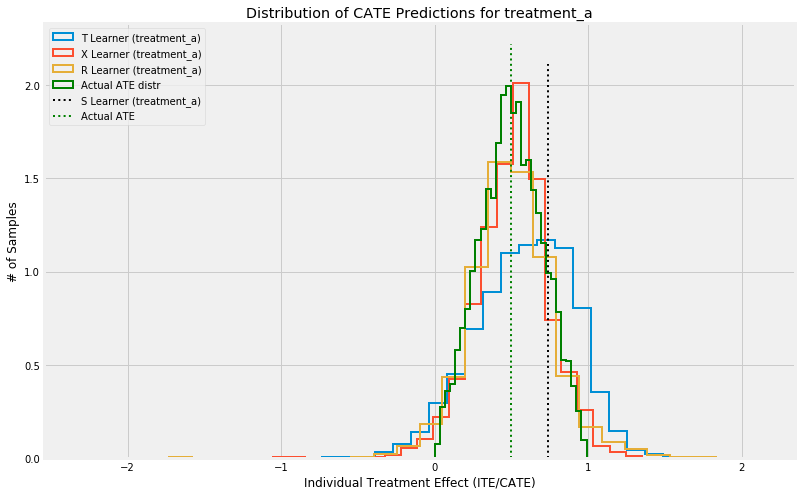

In [46]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 30
for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(cate_t[:,idx], alpha=alpha, bins=bins, label='T Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_x[:,idx], alpha=alpha, bins=bins, label='X Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_r[:,idx], alpha=alpha, bins=bins, label='R Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(tau, alpha=alpha, bins=bins, label='Actual ATE distr',
             histtype='step', linewidth=linewidth, color='green', density=True)
    plt.vlines(cate_s[0,idx], 0, plt.axes().get_ylim()[1], label='S Learner ({})'.format(group),
               linestyles='dotted', linewidth=linewidth)
    plt.vlines(tau.mean(), 0, plt.axes().get_ylim()[1], label='Actual ATE',
               linestyles='dotted', linewidth=linewidth, color='green')
    
    plt.title('Distribution of CATE Predictions for {}'.format(group))
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    _=plt.legend()

---
# Multiple Treatment Case

### Generate synthetic data
Note: we randomize the assignment of treatment flag AFTER the synthetic data generation process, so it doesn't make sense to measure accuracy metrics here. Next steps would be to include multi-treatment in the DGP itself.

In [47]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array([('treatment_a' if np.random.random() > 0.2 else 'treatment_b') 
                      if val==1 else 'control' for val in treatment])

e = {group: e for group in np.unique(treatment)}

In [48]:
pd.Series(treatment).value_counts()

control        4910
treatment_a    4108
treatment_b     982
dtype: int64

## S-Learner

### ATE

In [51]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False, bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9708
INFO:causalml:    RMSE (Treatment):     0.9523
INFO:causalml:   sMAPE   (Control):     0.8388
INFO:causalml:   sMAPE (Treatment):     0.4565
INFO:causalml:    Gini   (Control):     0.4408
INFO:causalml:    Gini (Treatment):     0.5081
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9577
INFO:causalml:    RMSE (Treatment):     0.9218
INFO:causalml:   sMAPE   (Control):     0.8294
INFO:causalml:   sMAPE (Treatment):     0.4647
INFO:causalml:    Gini   (Control):     0.4689
INFO:causalml:    Gini (Treatment):     0.5648


In [52]:
ate_s

array([0.62854011, 0.56932352])

In [53]:
learner_s._classes

{'treatment_a': 0, 'treatment_b': 1}

### ATE w/ Confidence Intervals

In [72]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                   bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9683
INFO:causalml:    RMSE (Treatment):     0.9677
INFO:causalml:   sMAPE   (Control):     0.8202
INFO:causalml:   sMAPE (Treatment):     0.4658
INFO:causalml:    Gini   (Control):     0.4669
INFO:causalml:    Gini (Treatment):     0.4983
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9591
INFO:causalml:    RMSE (Treatment):     0.9414
INFO:causalml:   sMAPE   (Control):     0.8157
INFO:causalml:   sMAPE (Treatment):     0.4572
INFO:causalml:    Gini   (Control):     0.4849
INFO:causalml:    Gini (Treatment):     0.5307


In [73]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.55780102, 0.5587663 ],
       [0.5982267 , 0.62208197],
       [0.63865238, 0.68539764]])

### ATE w/ Boostrap Confidence Intervals

In [74]:
ate_s_b, ate_s_lb_b, ate_s_ub_b = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                         bootstrap_ci=True, n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9683
INFO:causalml:    RMSE (Treatment):     0.9677
INFO:causalml:   sMAPE   (Control):     0.8202
INFO:causalml:   sMAPE (Treatment):     0.4658
INFO:causalml:    Gini   (Control):     0.4669
INFO:causalml:    Gini (Treatment):     0.4983
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9591
INFO:causalml:    RMSE (Treatment):     0.9414
INFO:causalml:   sMAPE   (Control):     0.8157
INFO:causalml:   sMAPE (Treatment):     0.4572
INFO:causalml:    Gini   (Control):     0.4849
INFO:causalml:    Gini (Treatment):     0.5307
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


In [75]:
np.vstack((ate_s_lb_b, ate_s_b, ate_s_ub_b))

array([[0.53158132, 0.53158132],
       [0.5982267 , 0.62208197],
       [0.66459518, 0.66459518]])

### CATE

In [76]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9683
INFO:causalml:    RMSE (Treatment):     0.9677
INFO:causalml:   sMAPE   (Control):     0.8202
INFO:causalml:   sMAPE (Treatment):     0.4658
INFO:causalml:    Gini   (Control):     0.4669
INFO:causalml:    Gini (Treatment):     0.4983
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9591
INFO:causalml:    RMSE (Treatment):     0.9414
INFO:causalml:   sMAPE   (Control):     0.8157
INFO:causalml:   sMAPE (Treatment):     0.4572
INFO:causalml:    Gini   (Control):     0.4849
INFO:causalml:    Gini (Treatment):     0.5307


In [77]:
cate_s

array([[0.34615517, 0.40926445],
       [0.38557369, 0.40354043],
       [0.65844643, 0.81348002],
       ...,
       [0.61916423, 0.83220744],
       [0.53607059, 0.63760078],
       [0.62724137, 0.56441128]])

### CATE w/ Confidence Intervals

In [78]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9683
INFO:causalml:    RMSE (Treatment):     0.9677
INFO:causalml:   sMAPE   (Control):     0.8202
INFO:causalml:   sMAPE (Treatment):     0.4658
INFO:causalml:    Gini   (Control):     0.4669
INFO:causalml:    Gini (Treatment):     0.4983
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9591
INFO:causalml:    RMSE (Treatment):     0.9414
INFO:causalml:   sMAPE   (Control):     0.8157
INFO:causalml:   sMAPE (Treatment):     0.4572
INFO:causalml:    Gini   (Control):     0.4849
INFO:causalml:    Gini (Treatment):     0.5307
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


In [79]:
cate_s

array([[0.34615517, 0.40926445],
       [0.38557369, 0.40354043],
       [0.65844643, 0.81348002],
       ...,
       [0.61916423, 0.83220744],
       [0.53607059, 0.63760078],
       [0.62724137, 0.56441128]])

In [80]:
cate_s_lb

array([[ 0.03391758, -0.12986364],
       [ 0.05919364,  0.04146205],
       [ 0.32714233,  0.23009048],
       ...,
       [ 0.2250985 ,  0.25903452],
       [ 0.15557972, -0.24358657],
       [ 0.3604196 ,  0.20320328]])

In [81]:
cate_s_ub

array([[0.77230242, 0.8918137 ],
       [0.59772992, 0.71897371],
       [0.90222054, 1.03450275],
       ...,
       [0.86580466, 0.97754339],
       [0.90745675, 1.1426337 ],
       [0.92506452, 0.97297716]])

## T-Learner

### ATE w/ Confidence Intervals

In [82]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9460
INFO:causalml:    RMSE (Treatment):     0.9320
INFO:causalml:   sMAPE   (Control):     0.8077
INFO:causalml:   sMAPE (Treatment):     0.4540
INFO:causalml:    Gini   (Control):     0.5118
INFO:causalml:    Gini (Treatment):     0.5507
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9460
INFO:causalml:    RMSE (Treatment):     0.7838
INFO:causalml:   sMAPE   (Control):     0.8077
INFO:causalml:   sMAPE (Treatment):     0.4056
INFO:causalml:    Gini   (Control):     0.5118
INFO:causalml:    Gini (Treatment):     0.7331


In [83]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.56295977, 0.62767078],
       [0.60261786, 0.68308432],
       [0.64227595, 0.73849785]])

### ATE w/ Boostrap Confidence Intervals

In [84]:
ate_t_b, ate_t_lb_b, ate_t_ub_b = learner_t.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9460
INFO:causalml:    RMSE (Treatment):     0.9320
INFO:causalml:   sMAPE   (Control):     0.8077
INFO:causalml:   sMAPE (Treatment):     0.4540
INFO:causalml:    Gini   (Control):     0.5118
INFO:causalml:    Gini (Treatment):     0.5507
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9460
INFO:causalml:    RMSE (Treatment):     0.7838
INFO:causalml:   sMAPE   (Control):     0.8077
INFO:causalml:   sMAPE (Treatment):     0.4056
INFO:causalml:    Gini   (Control):     0.5118
INFO:causalml:    Gini (Treatment):     0.7331
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


In [85]:
np.vstack((ate_t_lb_b, ate_t_b, ate_t_ub_b))

array([[0.57238376, 0.57238376],
       [0.60261786, 0.68308432],
       [0.73193772, 0.73193772]])

### CATE

In [86]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9460
INFO:causalml:    RMSE (Treatment):     0.9320
INFO:causalml:   sMAPE   (Control):     0.8077
INFO:causalml:   sMAPE (Treatment):     0.4540
INFO:causalml:    Gini   (Control):     0.5118
INFO:causalml:    Gini (Treatment):     0.5507
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9460
INFO:causalml:    RMSE (Treatment):     0.7838
INFO:causalml:   sMAPE   (Control):     0.8077
INFO:causalml:   sMAPE (Treatment):     0.4056
INFO:causalml:    Gini   (Control):     0.5118
INFO:causalml:    Gini (Treatment):     0.7331


In [87]:
cate_t

array([[-0.18926954,  0.50318325],
       [ 0.06817073,  0.32467365],
       [ 0.70596826,  0.56913936],
       ...,
       [ 0.53327358,  1.0912919 ],
       [-0.07503891,  0.70067358],
       [ 0.77251112,  0.54821527]])

### CATE w/ Confidence Intervals

In [88]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9460
INFO:causalml:    RMSE (Treatment):     0.9320
INFO:causalml:   sMAPE   (Control):     0.8077
INFO:causalml:   sMAPE (Treatment):     0.4540
INFO:causalml:    Gini   (Control):     0.5118
INFO:causalml:    Gini (Treatment):     0.5507
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9460
INFO:causalml:    RMSE (Treatment):     0.7838
INFO:causalml:   sMAPE   (Control):     0.8077
INFO:causalml:   sMAPE (Treatment):     0.4056
INFO:causalml:    Gini   (Control):     0.5118
INFO:causalml:    Gini (Treatment):     0.7331
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


In [89]:
cate_t

array([[-0.18926954,  0.50318325],
       [ 0.06817073,  0.32467365],
       [ 0.70596826,  0.56913936],
       ...,
       [ 0.53327358,  1.0912919 ],
       [-0.07503891,  0.70067358],
       [ 0.77251112,  0.54821527]])

In [90]:
cate_t_lb

array([[-0.59014446, -0.43322195],
       [-0.30633765, -0.56958698],
       [ 0.05350997, -0.35491131],
       ...,
       [ 0.10287107,  0.11906638],
       [-0.37459003, -0.55257832],
       [ 0.10846853, -0.07021846]])

In [91]:
cate_t_ub

array([[1.20079037, 1.72227209],
       [0.66422076, 0.98329674],
       [1.47297974, 1.75017764],
       ...,
       [1.04549127, 1.41742021],
       [0.99238015, 1.4525027 ],
       [1.24708976, 1.50783636]])

## X-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [49]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.9294
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.5508
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.7757
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4088
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.7321


In [50]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.45610032, 0.43704002],
       [0.49575071, 0.4932905 ],
       [0.53540111, 0.54954098]])

#### Without Propensity Score Input

In [51]:
ate_x_no_p, ate_x_lb_no_p, ate_x_ub_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.9294
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.5508
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.7757
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4088
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.7321


In [52]:
np.vstack((ate_x_lb_no_p, ate_x_no_p, ate_x_ub_no_p))

array([[0.46658499, 0.47143892],
       [0.5062432 , 0.52787549],
       [0.54590141, 0.58431207]])

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [53]:
ate_x_b, ate_x_lb_b, ate_x_ub_b = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.9294
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.5508
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.7757
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4088
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.7321
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [54]:
np.vstack((ate_x_lb_b, ate_x_b, ate_x_ub_b))

array([[0.42925984, 0.42925984],
       [0.49575071, 0.4932905 ],
       [0.60437059, 0.60437059]])

#### Without Propensity Score Input

In [55]:
ate_x_b_no_p, ate_x_lb_b_no_p, ate_x_ub_b_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.9294
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.5508
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.7757
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4088
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.7321
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


In [56]:
np.vstack((ate_x_lb_b_no_p, ate_x_b_no_p, ate_x_ub_b_no_p))

array([[0.44914401, 0.44914401],
       [0.5062432 , 0.52787549],
       [0.61806572, 0.61806572]])

### CATE

#### With Propensity Score Input

In [57]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.9294
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.5508
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.7757
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4088
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.7321


In [58]:
cate_x

array([[ 0.23485509,  0.34020972],
       [-0.54220046, -0.22854473],
       [ 0.64892673,  0.6692328 ],
       ...,
       [-0.06127331,  0.46481089],
       [ 0.69944974,  0.61236475],
       [ 0.56022477,  0.51039938]])

#### Without Propensity Score Input

In [59]:
cate_x_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.9294
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.5508
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.7757
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4088
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.7321


In [60]:
cate_x_no_p

array([[ 0.24538066,  0.52825429],
       [-0.55448328, -0.26970306],
       [ 0.70481063,  0.86122739],
       ...,
       [ 0.0378903 ,  0.4603416 ],
       [ 0.67250272,  0.5947758 ],
       [ 0.54894876,  0.50496594]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [61]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.9294
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.5508
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.7757
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4088
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.7321
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:30<00:00,  3.28it/s]


In [62]:
learner_x._classes

{'treatment_a': 0, 'treatment_b': 1}

In [63]:
cate_x

array([[ 0.23485509,  0.34020972],
       [-0.54220046, -0.22854473],
       [ 0.64892673,  0.6692328 ],
       ...,
       [-0.06127331,  0.46481089],
       [ 0.69944974,  0.61236475],
       [ 0.56022477,  0.51039938]])

In [64]:
cate_x_lb

array([[-0.68985469, -0.90820051],
       [-0.89942996, -1.15647117],
       [-0.07759029, -0.13457286],
       ...,
       [-1.57063298, -0.65095499],
       [-0.45222382, -0.69058035],
       [-0.172778  , -0.36900492]])

In [65]:
cate_x_ub

array([[1.67427426, 1.44555171],
       [0.71914726, 1.0187736 ],
       [1.46582848, 1.59607857],
       ...,
       [1.47426543, 1.77275821],
       [2.39091008, 1.82280986],
       [1.07427553, 1.36362469]])

#### Without Propensity Score Input

In [66]:
cate_x_no_p, cate_x_lb_no_p, cate_x_ub_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.9294
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4697
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.5508
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.9655
INFO:causalml:    RMSE (Treatment):     0.7757
INFO:causalml:   sMAPE   (Control):     0.8148
INFO:causalml:   sMAPE (Treatment):     0.4088
INFO:causalml:    Gini   (Control):     0.5038
INFO:causalml:    Gini (Treatment):     0.7321
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


In [67]:
learner_x._classes

{'treatment_a': 0, 'treatment_b': 1}

In [68]:
cate_x_no_p

array([[ 0.24538066,  0.52825429],
       [-0.55448328, -0.26970306],
       [ 0.70481063,  0.86122739],
       ...,
       [ 0.0378903 ,  0.4603416 ],
       [ 0.67250272,  0.5947758 ],
       [ 0.54894876,  0.50496594]])

In [69]:
cate_x_lb_no_p

array([[-0.51019995, -0.9760952 ],
       [-0.92137106, -1.25861078],
       [ 0.22915193, -0.23361977],
       ...,
       [-1.35537712, -1.11661583],
       [-0.80456833, -0.83644243],
       [-0.17550065, -0.57355474]])

In [70]:
cate_x_ub_no_p

array([[1.30033429, 1.15436519],
       [1.00197264, 1.21509172],
       [1.68042388, 1.96692795],
       ...,
       [1.31858898, 2.19260638],
       [1.71224514, 1.94443248],
       [1.17473544, 1.68530673]])

## R-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [71]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [72]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.47763659, 0.50888857],
       [0.47805162, 0.5095427 ],
       [0.47846665, 0.51019683]])

#### Without Propensity Score Input

In [73]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r_no_p, ate_r_lb_no_p, ate_r_ub_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [74]:
np.vstack((ate_r_lb_no_p, ate_r_no_p, ate_r_ub_no_p))

array([[0.46395336, 0.47914521],
       [0.46436792, 0.47980238],
       [0.46478248, 0.48045955]])

In [75]:
learner_r.propensity_model

{'treatment_a': {1: ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
               l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
               normalize=False, positive=False, precompute='auto',
               random_state=None, selection='cyclic', tol=0.0001, verbose=0),
  2: ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
               l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
               normalize=False, positive=False, precompute='auto',
               random_state=None, selection='cyclic', tol=0.0001, verbose=0),
  3: ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
               l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
               normalize=False, positive=False, precompute='auto',
               random_state=None, selection='cyclic', tol=0.0001, verbose=0),
  4: ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [76]:
ate_r_b, ate_r_lb_b, ate_r_ub_b = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [04:41<00:00,  2.81s/it]


In [77]:
np.vstack((ate_r_lb_b, ate_r_b, ate_r_ub_b))

array([[0.42824393, 0.42824393],
       [0.48199098, 0.52164791],
       [0.57424706, 0.57424706]])

#### Without Propensity Score Input

In [78]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r_b_no_p, ate_r_lb_b_no_p, ate_r_ub_b_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [04:49<00:00,  2.90s/it]


In [79]:
np.vstack((ate_r_lb_b_no_p, ate_r_b_no_p, ate_r_ub_b_no_p))

array([[0.41582709, 0.41582709],
       [0.45698746, 0.48285544],
       [0.56367815, 0.56367815]])

### CATE

#### With Propensity Score Input

In [80]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [81]:
cate_r

array([[ 0.49506277,  0.20567122],
       [-0.14570343,  0.2070145 ],
       [ 0.79710448,  0.54107785],
       ...,
       [-0.42962635,  0.35245821],
       [ 0.62423658,  0.98146856],
       [ 0.51859075,  0.39519885]])

#### Without Propensity Score Input

In [82]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Training a propensity model for CV #1
INFO:causalml:Training a propensity model for CV #2
INFO:causalml:Training a propensity model for CV #3
INFO:causalml:Training a propensity model for CV #4
INFO:causalml:Training a propensity model for CV #5
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [83]:
cate_r_no_p

array([[ 0.61800069, -0.00788629],
       [-0.04218817, -0.0058434 ],
       [ 0.84054393,  0.56681579],
       ...,
       [-0.45959288,  0.98543644],
       [ 0.7640394 ,  1.38348269],
       [ 0.42351735,  0.46819562]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [84]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


In [85]:
cate_r

array([[ 0.58448172, -0.2680496 ],
       [-0.23571336, -0.01736015],
       [ 0.72400343,  0.73520041],
       ...,
       [-0.40583944,  0.4874844 ],
       [ 0.39553338,  0.77179897],
       [ 0.47617459,  0.45489419]])

In [86]:
cate_r_lb

array([[-1.38822075, -1.40740092],
       [-0.94426446, -0.69641187],
       [-0.71931499, -0.98957596],
       ...,
       [-1.68231822, -0.71695195],
       [-1.04645931, -1.10758416],
       [-0.75947519, -1.42039528]])

In [87]:
cate_r_ub

array([[1.77444212, 2.04891262],
       [1.42491398, 1.86264497],
       [2.59757973, 2.21219535],
       ...,
       [2.19243523, 2.79646381],
       [2.885914  , 2.57060448],
       [1.6964736 , 1.46194966]])

#### Without Propensity Score Input

In [88]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r_no_p, cate_r_lb_no_p, cate_r_ub_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [03:46<00:00,  2.26s/it]


In [89]:
cate_r_no_p

array([[ 0.47493669,  0.47304517],
       [-0.29426128, -0.04735339],
       [ 0.73216939,  0.94916141],
       ...,
       [-0.47460735,  0.4052009 ],
       [ 0.57141131,  0.53277904],
       [ 0.51551974,  0.44686833]])

In [90]:
cate_r_lb_no_p

array([[-1.58349195, -1.88796993],
       [-0.80328908, -1.22721922],
       [-0.16996011, -0.7000859 ],
       ...,
       [-1.11082214, -0.54313161],
       [-0.67417825, -1.26722633],
       [-0.96193685, -0.8944903 ]])

In [91]:
cate_r_ub_no_p

array([[2.2367514 , 2.40854006],
       [1.31074977, 1.97296876],
       [2.54154972, 2.85698386],
       ...,
       [2.08907185, 2.11179618],
       [2.62199878, 2.25089631],
       [1.4804768 , 1.67883015]])